# Spot the Mask Challenge

## If using Colab

In [0]:
import os, random

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
path = "drive/My Drive/Colab Notebooks/Spot the Mask"
os.chdir(path)
!ls

## Import Libraries

In [0]:
!pip install albumentations
!pip install pretrainedmodels

In [0]:
import os, sys, gc
import numpy as np
import pandas as pd
import random
import copy
from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import *

from PIL import Image
import albumentations
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from random import shuffle 
%matplotlib inline

In [7]:
def is_interactive():
    return 'runtime' in get_ipython().config.IPKernelApp.connection_file

print('Interactive?', is_interactive())

Interactive? True


In [0]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(2020)

In [0]:
print(torch.__version__)
print(torch.cuda.is_available())

In [0]:
path = './'
train_dir = path+'images'
test_dir = path+'images'
df = pd.read_csv(path+'train_labels.csv')
df_sample = pd.read_csv(path+'sample_sub_v2.csv')
df.head(1)

## Create Folds

In [0]:
df.loc[:, 'kfold'] = -1
df = df.sample(frac=1).reset_index(drop=True)

In [0]:
X = df.image.values
y = df.target.values

In [0]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

folds = StratifiedKFold(n_splits=5)

for fold, (trn_, val_) in enumerate(folds.split(X, y)):
    df.loc[val_, "kfold"] = fold

print(df.kfold.value_counts())
df.to_csv("./input/train_folds.csv", index=False)

## Set Environment Variables

In [0]:
device = "cuda"
bs = 16
bs_test = 16
training_folds_csv = "./input/train_folds.csv"
df_folds = pd.read_csv(training_folds_csv)

## Load Train Data From DataFrame

In [0]:
class from_df(Dataset):
    def __init__(self, dir, df, folds, image_class, mode='train'):
        self.mode= mode
        
        if self.mode == 'train':
            df = df[df.kfold.isin(folds)].reset_index(drop=True)
            self.image_list = [x for x in df[image_class[0]]]
            self.target_list = [x for x in df[image_class[1]]]
            self.df = df
            self.no_of_classes = len(df[image_class[1]].value_counts())
            if len(folds) == 1: # if validation
                self.transform = albumentations.Compose([
                    albumentations.Resize(256, 256, always_apply=True),
                    albumentations.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225), always_apply=True)
                ])
            else:
                self.transform = albumentations.Compose([
                    albumentations.Resize(256, 256, always_apply=True),
                    albumentations.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=5, p=0.9),
                    albumentations.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225), always_apply=True)
                ])
        else:
            self.image_list = [x for x in df[image_class]]
            self.df = df
            self.no_of_classes = 0
            self.transform = albumentations.Compose([
                albumentations.Resize(256, 256, always_apply=True),
                albumentations.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225), always_apply=True)
            ])
            
        self.dir = dir
        self.image_class = image_class
            
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.image_list[idx]))
        img = img.convert("RGB")
        img = self.transform(image=np.array(img))['image']
        img = np.transpose(img, (2, 0, 1)).astype('float32')
        if self.mode == 'train':
            return torch.tensor(img, dtype=torch.float), self.target_list[idx]
        else:
            return torch.tensor(img, dtype=torch.float), self.image_list[idx]

    def info(self):
        print("Number of Classes:", self.no_of_classes)

## Model Building

In [0]:
import pretrainedmodels
import torch.nn as nn
from torch.nn import functional as F

class Se_ResNext101_32x4d(nn.Module):
    def __init__(self, pretrained):
        super(Se_ResNext101_32x4d, self).__init__()
        if pretrained == True:
            self.model = pretrainedmodels.__dict__["se_resnext101_32x4d"](pretrained='imagenet')
        else:
            self.model = pretrainedmodels.__dict__["se_resnext101_32x4d"](pretrained=None)
        
        self.l0 = nn.Linear(2048, 2)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        l0 = self.l0(x)
        return l0 

class SeNet154(nn.Module):
    def __init__(self, pretrained):
        super(SeNet154, self).__init__()
        if pretrained == True:
            self.model = pretrainedmodels.__dict__["senet154"](pretrained='imagenet')
        else:
            self.model = pretrainedmodels.__dict__["senet154"](pretrained=None)

        if requires_grad == False:
          # Freeze parameters
          for param in self.model.parameters():
              print("Freezed parameters")
              param.requires_grad = False
        
        self.l0 = nn.Linear(2048, 2)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        l0 = self.l0(x)
        return l0 

In [0]:
model_dispatcher = {
    "se_resnext101_32x4d": Se_ResNext101_32x4d,
    "senet154": SeNet154,
}

In [0]:
model = model_dispatcher['senet154'](pretrained=False)
model

## Training

In [0]:
base_model = "senet154"
model = model_dispatcher[base_model](pretrained=True)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # Train full architecture
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=5, factor=0.3, verbose=True)
early_stopping = EarlyStopping(patience=7, verbose=True)

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [0]:
def loss_fn(outputs, targets):
    loss = nn.CrossEntropyLoss()(outputs, targets)
    return loss

def train(dataset, data_loader, model, optimizer):
    model.train()
    final_loss = 0
    counter = 0
    for bi, (images, labels) in tqdm(enumerate(data_loader), total=int(len(dataset)/data_loader.batch_size)):
        counter += 1
        images, labels = images.to(device, dtype=torch.float), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        
        loss.backward()
        optimizer.step()

        final_loss += loss
    return final_loss/counter
        
def evaluate(dataset, data_loader, model):
    # model.eval()
    # final_loss = 0
    # counter = 0
    # for bi, (images, labels) in tqdm(enumerate(data_loader), total=int(len(dataset)/data_loader.batch_size)):
    #     counter += 1
    #     images, labels = images.to(device, dtype=torch.float), labels.to(device)
        
    #     outputs = model(images)
    #     targets = (labels)
    #     loss = loss_fn(outputs, targets)
    #     final_loss += loss
    # return final_loss/counter

    model.eval()
    images, labels = iter(data_loader).next()
    images, labels = images.to(device, dtype=torch.float), labels.to(device)
    outputs = model(images)
    targets = (labels)
    loss = loss_fn(outputs, targets)
    return loss

## Train on Full Dataset

In [0]:
train_dataset = from_df(train_dir, df_folds, (0, 1, 2, 3, 4), ('image', 'target'))
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True, num_workers=4)

epochs = 50 
save_dir = 'models/'

for epoch in range(epochs):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    train_score = train(train_dataset, train_loader, model, optimizer)
    scheduler.step(train_score)

torch.save(model.state_dict(), save_dir+"model.pt")

## Load Model

In [0]:
def load_checkpoint(file=save_dir+'model.pt'):
    model_state = torch.load(file, map_location=lambda storage, loc: storage)
    model.load_state_dict(model_state, strict=False)
    return model

model = load_checkpoint()
model = model.to(device)

## Load Test Data

In [0]:
testset = from_df(test_dir, df_sample, validation_folds, 'image', mode='test')
testloader = DataLoader(testset, batch_size = 64, shuffle=False, num_workers=4)

## Testing

In [0]:
model.eval()
fn_list = []
pred_list = []
for x, fn in testloader:
    with torch.no_grad():
        x = x.to(device)
        output = model(x)
        pred = torch.sigmoid(output)[:, 1]
        fn_list += [n for n in fn]
        pred_list += [p.item() for p in pred]

submission = pd.DataFrame(np.stack([fn_list, pred_list], axis=1), columns=df_sample.columns)
submission.to_csv('submission.csv', index=False)

In [31]:
submission.head()

,image,target
0,aadawlxbmapqrblgxyzarhjasgiobu.png,0.9933986663818359
1,abpxvdfyhaaohzcrngcucmhffwizxs.jpg,2.4645458324812353e-05
2,aclkjfvackiieiznzfcwienplielrj.jpg,0.9988453388214111
3,aelkivmayxgsdjosiibfgmkvfrjvjk.jpg,0.9986704587936401
4,aelzzshpfxerelefnkatpczktuxjln.jpg,0.0007269643247127533


In [32]:
len(df_sample['image']==submission['image'])

509

## Validation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

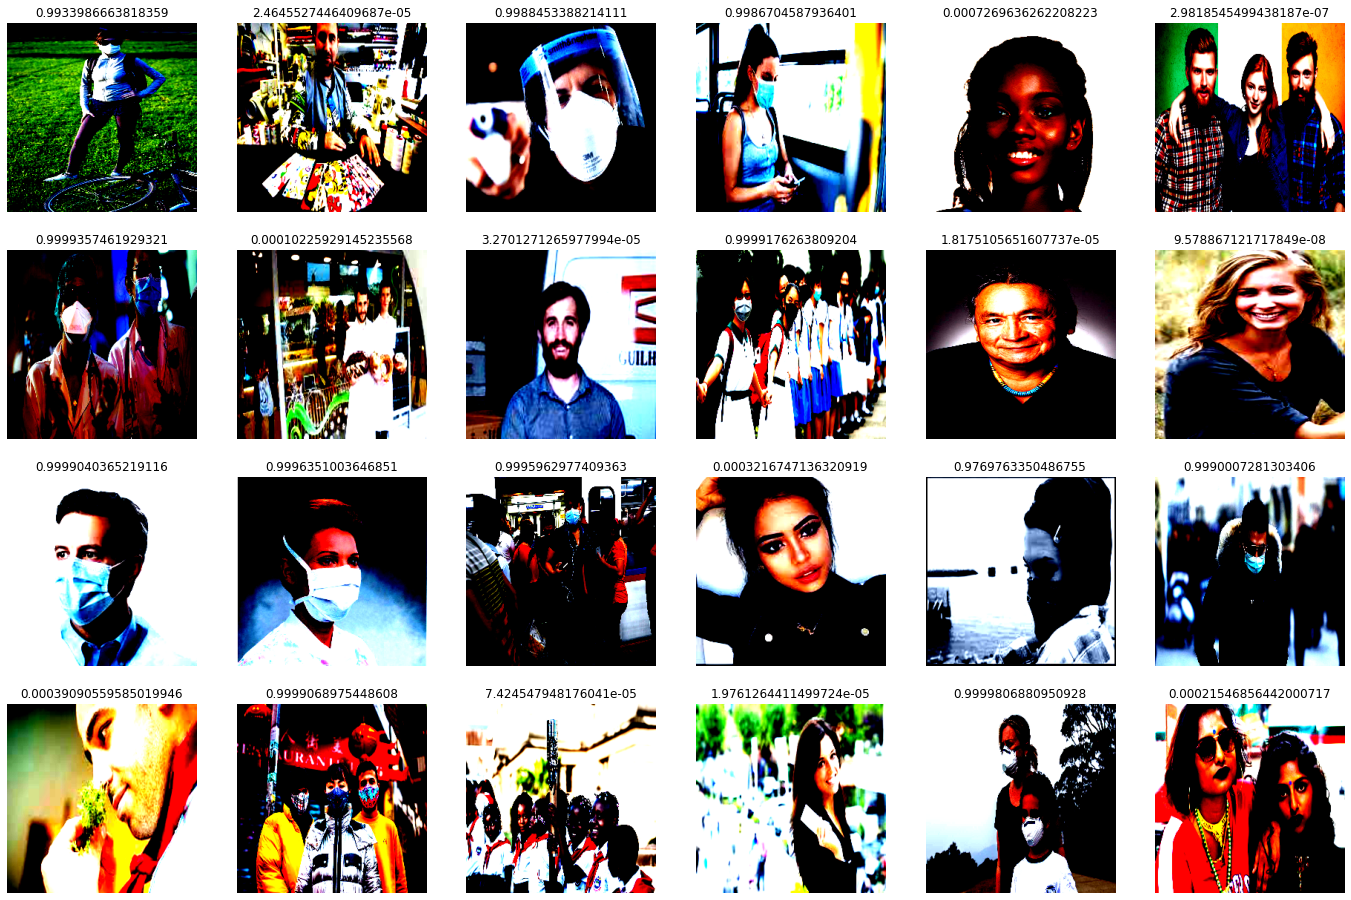

In [33]:
samples, _ = iter(testloader).next()
samples = samples.to(device)
fig = plt.figure(figsize=(24, 16))
fig.tight_layout()
output = model(samples[:24])
pred = torch.sigmoid(output)[:, 1]
pred = [p.item() for p in pred]
for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(pred[num])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))